In [1]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56437 sha256=349a74cb100387de8aed0b8f250b48199901c15337232b700cc3c977283fee86
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import itertools
from wordcloud import WordCloud
from sklearn.svm import SVC
from keras.models import Sequential,Model
from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding
from keras.utils import to_categorical
from joblib import dump, load

In [3]:
text = []
clas = []
df = pd.read_csv('labeled_data.csv')
text = df['tweet'].tolist()
clas = df['class'].tolist()

df = pd.DataFrame({'tweet': text, 'class': clas})

In [4]:
print(df.isnull().sum())
df['tweet'] = df['tweet'].apply(lambda x:x.lower())
punctuation_signs = list("?:!.,;")
df['tweet'] = df['tweet']

for punct_sign in punctuation_signs:
    df['tweet'] = df['tweet'].str.replace(punct_sign, '')

df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ' '))
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ' '))
df['tweet'] = df['tweet'].str.replace("    ", " ")
df['tweet'] = df['tweet'].str.replace('"', '')
df['tweet'] = df['tweet'].str.replace("'s", "")

tweet    0
class    0
dtype: int64


In [5]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['tweet'] = df['tweet'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
cv = CountVectorizer(max_features = 75)
X = cv.fit_transform(df['tweet']).toarray()
y = df['class']

In [7]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)



In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:


y_train=to_categorical(y_train, num_classes = 3)
y_test=to_categorical(y_test, num_classes = 3)



In [9]:
model = Sequential()
model.add(Embedding(232337, 100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 25
batch_size = 64

history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/25
310/310 [==============================] - 87s 262ms/step - loss: 0.4235 - accuracy: 0.7685 - val_loss: 0.4025 - val_accuracy: 0.7743
Epoch 2/25
310/310 [==============================] - 92s 298ms/step - loss: 0.4027 - accuracy: 0.7743 - val_loss: 0.4024 - val_accuracy: 0.7743
Epoch 3/25
310/310 [==============================] - 91s 294ms/step - loss: 0.4023 - accuracy: 0.7743 - val_loss: 0.4024 - val_accuracy: 0.7743
Epoch 4/25
310/310 [==============================] - 79s 254ms/step - loss: 0.4017 - accuracy: 0.7743 - val_loss: 0.4026 - val_accuracy: 0.7743
Epoch 5/25
310/310 [==============================] - 78s 253ms/step - loss: 0.4008 - accuracy: 0.7743 - val_loss: 0.4019 - val_accuracy: 0.7743
Epoch 6/25
310/310 [==============================] - 79s 254ms/step - loss: 0.4005 - accuracy: 0.7743 - val_loss: 0.4024 - val_accuracy: 0.7743
Epoch 7/25
310/310 [==============================] - 77s 248ms/step - loss: 0.4002 - accuracy: 0.7743 - val_loss: 0.4018 - val_ac

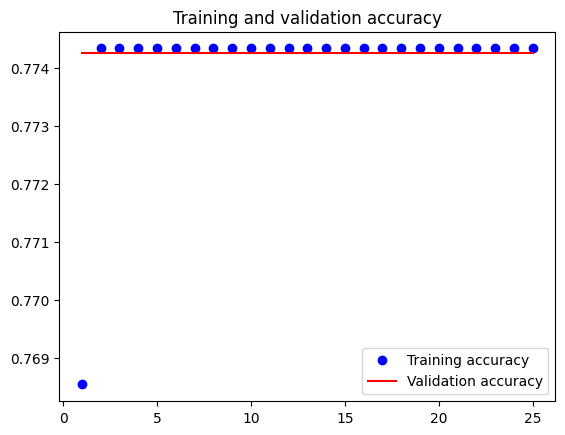

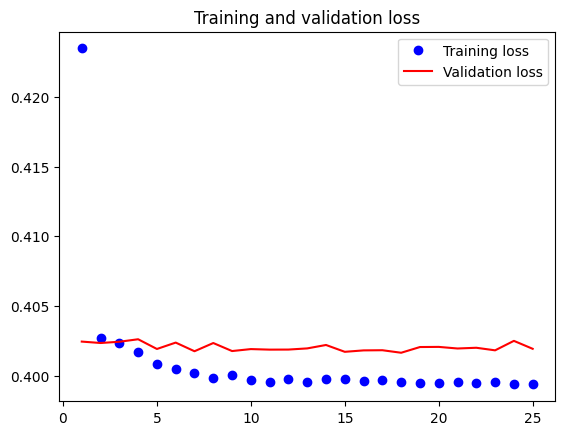

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
model.save('lstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from wordcloud import WordCloud

In [12]:
# Predict and calculate confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

155/155 [==============================] - 4s 22ms/step


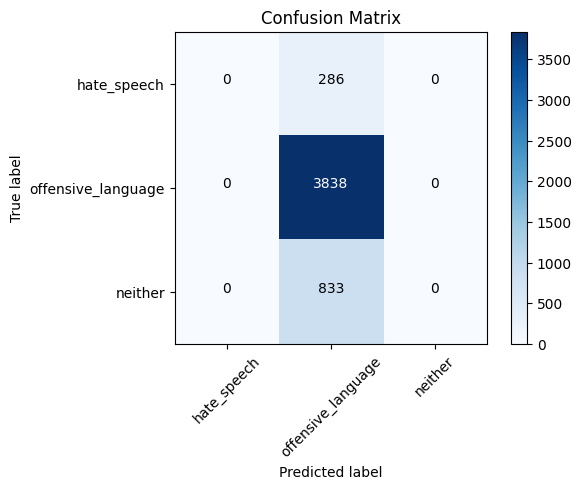

In [14]:
class_names = ['hate_speech', 'offensive_language', 'neither']
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from scipy.sparse import vstack

# Step 1: Split data into labeled and unlabeled pools
initial_labeled_ratio = 0.1  # Start with 10% labeled data
X_train, X_unlabeled, y_train, y_unlabeled = train_test_split(df['tweet'], df['class'], test_size=1-initial_labeled_ratio, random_state=42, stratify=df['class'])

# Step 2: Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_unlabeled_vec = vectorizer.transform(X_unlabeled)

# Step 3: Train the initial model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Step 4: Active learning loop
num_iterations = 10
samples_per_iteration = 100

for i in range(num_iterations):
    # Predict probabilities on the unlabeled data
    probs = model.predict_proba(X_unlabeled_vec)
    uncertainties = np.max(probs, axis=1)

    # Select the most uncertain samples
    uncertain_indices = uncertainties.argsort()[:samples_per_iteration]
    X_new_train = X_unlabeled.iloc[uncertain_indices]
    y_new_train = y_unlabeled.iloc[uncertain_indices]

    # Remove the selected samples from the unlabeled pool using positional indices
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[uncertain_indices])
    y_unlabeled = y_unlabeled.drop(y_unlabeled.index[uncertain_indices])
    X_unlabeled_vec = vectorizer.transform(X_unlabeled)

    # Transform the new samples with the existing vectorizer
    X_new_train_vec = vectorizer.transform(X_new_train)

    # Append new samples to the training set
    X_train_vec = vstack((X_train_vec, X_new_train_vec))
    y_train = pd.concat([y_train, y_new_train])

    # Retrain the model
    model.fit(X_train_vec, y_train)

    # Evaluate the model
    y_pred = model.predict(X_train_vec)
    accuracy = accuracy_score(y_train, y_pred)
    print(f"Iteration {i+1}/{num_iterations}, Accuracy: {accuracy:.4f}")

# Step 5: Final evaluation
y_pred_final = model.predict(vectorizer.transform(df['tweet']))
final_accuracy = accuracy_score(df['class'], y_pred_final)
print(f"Final Accuracy: {final_accuracy:.4f}")


Iteration 1/10, Accuracy: 0.9558
Iteration 2/10, Accuracy: 0.9526
Iteration 3/10, Accuracy: 0.9521
Iteration 4/10, Accuracy: 0.9514
Iteration 5/10, Accuracy: 0.9476
Iteration 6/10, Accuracy: 0.9467
Iteration 7/10, Accuracy: 0.9427
Iteration 8/10, Accuracy: 0.9387
Iteration 9/10, Accuracy: 0.9364
Iteration 10/10, Accuracy: 0.9321
Final Accuracy: 0.8955
